In [61]:
%pip install scikit-learn

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [62]:
def load_data():
    matches = pd.read_csv("matches.csv", index_col=0)
    matches["date"] = pd.to_datetime(matches["date"])
    
    class MissingDict(dict):
        __missing__ = lambda self, key: key
    map_values = {
            "Brighton and Hove Albion" : "Brighton",
            "Manchester United" : "Manchester Utd",
            "Newcastle United" : "Newcastle Utd",
            "Tottenham Hotspur" : "Tottenham",
            "West Ham United" : "West Ham",
            "Wolverhampton Wanderers" : "Wolves",
            "West Brom" : "West Bromwich Albion",
            "Sheffield United": "Sheffield Utd",
    }
    mapping = MissingDict(**map_values)
    matches["team"] = matches["team"].map(mapping)
    matches["opponent"] = matches["opponent"].map(mapping)
    
    return matches

matches = load_data()

# Display first few rows and basic information
print("Dataset Shape:", matches.shape)
print("\nFirst few rows:")
display(matches.head())
print("\nColumns:")
display(matches.columns)

Dataset Shape: (1389, 27)

First few rows:


,date,time,comp,round,day,venue,result,gf,ga,opponent,...,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
1,2021-08-15,16:30,Premier League,Matchweek 1,Sun,Away,L,0.0,1.0,Tottenham,...,Match Report,NaN,18.0,4.0,16.9,1.0,0.0,0.0,2022,Manchester City
2,2021-08-21,15:00,Premier League,Matchweek 2,Sat,Home,W,5.0,0.0,Norwich City,...,Match Report,NaN,16.0,4.0,17.3,1.0,0.0,0.0,2022,Manchester City
3,2021-08-28,12:30,Premier League,Matchweek 3,Sat,Home,W,5.0,0.0,Arsenal,...,Match Report,NaN,25.0,10.0,14.3,0.0,0.0,0.0,2022,Manchester City
4,2021-09-11,15:00,Premier League,Matchweek 4,Sat,Away,W,1.0,0.0,Leicester City,...,Match Report,NaN,25.0,8.0,14.0,0.0,0.0,0.0,2022,Manchester City
6,2021-09-18,15:00,Premier League,Matchweek 5,Sat,Home,D,0.0,0.0,Southampton,...,Match Report,NaN,16.0,1.0,15.7,1.0,0.0,0.0,2022,Manchester City



Columns:


Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team'],
      dtype='object')

In [63]:
def validate_team_names(matches):
    all_teams = set(matches['team'].unique()) | set(matches['opponent'].unique())
    print("All unique team names in dataset:")
    for team in sorted(all_teams):
        print(f"- {team}")
    return all_teams

# Use it after loading data
matches = load_data()
team_names = validate_team_names(matches)

All unique team names in dataset:
- Arsenal
- Aston Villa
- Brentford
- Brighton
- Burnley
- Chelsea
- Crystal Palace
- Everton
- Fulham
- Leeds United
- Leicester City
- Liverpool
- Manchester City
- Manchester Utd
- Newcastle Utd
- Norwich City
- Sheffield Utd
- Southampton
- Tottenham
- Watford
- West Bromwich Albion
- West Ham
- Wolves


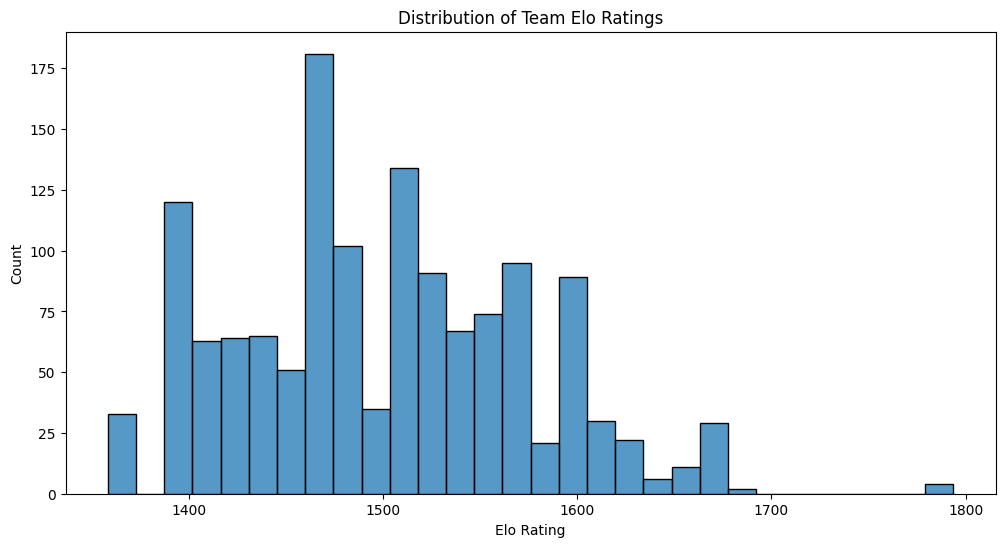

In [64]:
def calculate_elo(matches):
    # Initialize Elo ratings
    elo_dict = {}
    k_factor = 32
    
    for team in matches['team'].unique():
        elo_dict[team] = 1500
    
    matches = matches.sort_values('date')
    
    def expected_score(rating_a, rating_b):
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    matches['team_elo'] = 0
    matches['opp_elo'] = 0
    matches['team_elo_diff'] = 0
    
    for idx, match in matches.iterrows():
        team = match['team']
        opponent = match['opponent']
        
        # Get current Elo ratings
        team_elo = elo_dict[team]
        opp_elo = elo_dict[opponent]
        
        # Store Elo ratings and difference
        matches.at[idx, 'team_elo'] = team_elo
        matches.at[idx, 'opp_elo'] = opp_elo
        matches.at[idx, 'team_elo_diff'] = team_elo - opp_elo
        
        # Calculate expected scores
        team_expected = expected_score(team_elo, opp_elo)
        
        # Update Elo ratings based on actual result
        if match['result'] == 'W':
            team_actual = 1
        elif match['result'] == 'L':
            team_actual = 0
        else:
            team_actual = 0.5
        
        # Calculate new ratings
        team_new_elo = team_elo + k_factor * (team_actual - team_expected)
        opp_new_elo = opp_elo + k_factor * ((1 - team_actual) - (1 - team_expected))
        
        # Update ratings dictionary
        elo_dict[team] = team_new_elo
        elo_dict[opponent] = opp_new_elo
    
    return matches

matches = calculate_elo(matches)

# Visualize Elo distributions
plt.figure(figsize=(12, 6))
sns.histplot(matches['team_elo'], bins=30)
plt.title('Distribution of Team Elo Ratings')
plt.xlabel('Elo Rating')
plt.ylabel('Count')
plt.show()

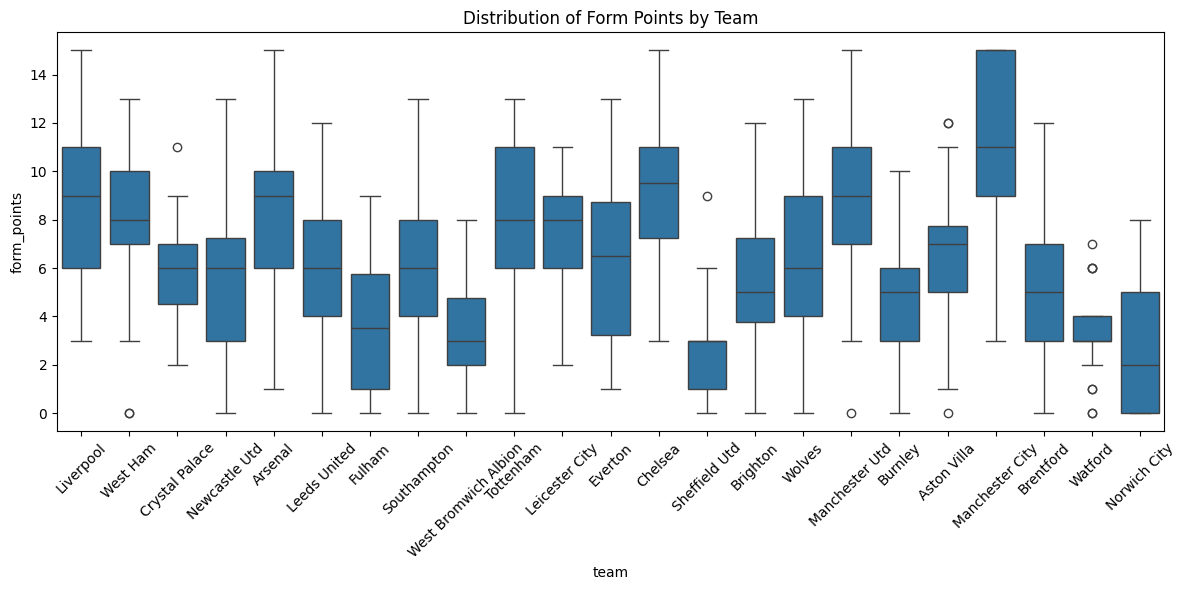

In [65]:
def add_form_features(matches):
    # Calculate form (last 5 matches)
    def convert_result_to_points(result):
        points = {'W': 3, 'D': 1, 'L': 0}
        return points[result]
    
    matches = matches.sort_values('date')
    
    # First convert results to points
    matches['result_points'] = matches['result'].apply(convert_result_to_points)
    
    # Then calculate rolling form
    matches['form_points'] = matches.groupby('team')['result_points'].transform(
        lambda x: x.rolling(5, min_periods=1).sum()
    )
    
    # Head-to-head features
    matches['h2h_wins'] = 0
    matches['h2h_draws'] = 0
    matches['h2h_losses'] = 0
    
    for idx, match in matches.iterrows():
        team = match['team']
        opponent = match['opponent']
        date = match['date']
        
        # Get head-to-head history
        h2h_history = matches[
            (matches['date'] < date) &
            (((matches['team'] == team) & (matches['opponent'] == opponent)) |
             ((matches['team'] == opponent) & (matches['opponent'] == team)))
        ]
        
        if not h2h_history.empty:
            team_matches = h2h_history[h2h_history['team'] == team]
            matches.at[idx, 'h2h_wins'] = sum(team_matches['result'] == 'W')
            matches.at[idx, 'h2h_draws'] = sum(team_matches['result'] == 'D')
            matches.at[idx, 'h2h_losses'] = sum(team_matches['result'] == 'L')
    
    # Drop the intermediate column
    matches = matches.drop('result_points', axis=1)
    
    return matches

matches = add_form_features(matches)

# Visualize form points distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='team', y='form_points', data=matches)
plt.xticks(rotation=45)
plt.title('Distribution of Form Points by Team')
plt.tight_layout()
plt.show()

In [73]:
def preprocess_data(matches):
    # Basic preprocessing
    matches["venue_code"] = matches["venue"].astype("category").cat.codes
    matches["opp_code"] = matches["opponent"].astype("category").cat.codes
    matches["hour"] = matches["time"].str.replace(":.+","", regex=True).astype("int")
    matches["day_code"] = matches["date"].dt.dayofweek
    
    # Add target variable
    matches["target"] = (matches["result"] == "W").astype("int")

    # Calculate Elo ratings (using your existing calculate_elo function)
    matches = calculate_elo(matches)
    
    # Add form features (using your existing add_form_features function)
    matches = add_form_features(matches)
    
    # Calculate rolling averages with multiple windows
    cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
    windows = [3, 5, 10]
    
    for window in windows:
        new_cols = [f"{c}_rolling_{window}" for c in cols]
        
        def rolling_averages(group, cols, new_cols):
            group = group.sort_values("date")
            rolling_stats = group[cols].rolling(window, closed='left').mean()
            group[new_cols] = rolling_stats
            return group
        
        matches = matches.groupby("team").apply(
            lambda x: rolling_averages(x, cols, new_cols)
        ).reset_index(drop=True)
    
    # Calculate goal difference features
    for window in windows:
        matches[f'goal_diff_rolling_{window}'] = (
            matches[f'gf_rolling_{window}'] - matches[f'ga_rolling_{window}']
        )
    
    # Drop rows with NaN values    
    return matches

matches_processed = preprocess_data(matches)
matches_processed.shape

# Display feature information
print("Processed dataset shape:", matches_processed.shape)
print("\nFeature names:")
display(matches_processed.columns)


Processed dataset shape: (1389, 66)

Feature names:


Index(['date', 'time', 'comp', 'round', 'day', 'venue', 'result', 'gf', 'ga',
       'opponent', 'xg', 'xga', 'poss', 'attendance', 'captain', 'formation',
       'referee', 'match report', 'notes', 'sh', 'sot', 'dist', 'fk', 'pk',
       'pkatt', 'season', 'team', 'team_elo', 'opp_elo', 'team_elo_diff',
       'form_points', 'h2h_wins', 'h2h_draws', 'h2h_losses', 'venue_code',
       'opp_code', 'hour', 'day_code', 'target', 'gf_rolling_3',
       'ga_rolling_3', 'sh_rolling_3', 'sot_rolling_3', 'dist_rolling_3',
       'fk_rolling_3', 'pk_rolling_3', 'pkatt_rolling_3', 'gf_rolling_5',
       'ga_rolling_5', 'sh_rolling_5', 'sot_rolling_5', 'dist_rolling_5',
       'fk_rolling_5', 'pk_rolling_5', 'pkatt_rolling_5', 'gf_rolling_10',
       'ga_rolling_10', 'sh_rolling_10', 'sot_rolling_10', 'dist_rolling_10',
       'fk_rolling_10', 'pk_rolling_10', 'pkatt_rolling_10',
       'goal_diff_rolling_3', 'goal_diff_rolling_5', 'goal_diff_rolling_10'],
      dtype='object')

In [74]:
basic_predictors = ["venue_code", "opp_code", "hour", "day_code"]
elo_predictors = ["team_elo", "opp_elo", "team_elo_diff"]
form_predictors = ["form_points", "h2h_wins", "h2h_draws", "h2h_losses"]
rolling_predictors = []

for window in [3, 5, 10]:
    for col in ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]:
        rolling_predictors.append(f"{col}_rolling_{window}")
    rolling_predictors.append(f"goal_diff_rolling_{window}")

all_predictors = basic_predictors + elo_predictors + form_predictors + rolling_predictors

# Prepare features and target

X = matches_processed[all_predictors]
y = matches_processed["target"]

matches.shape



(1389, 39)

In [75]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (1111, 38)
Test set shape: (278, 38)


In [98]:
# Create and train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1,
    random_state=42,
    early_stopping_rounds=50, # Stop if no improvement for 50 rounds
    eval_metric='logloss'  # Specify evaluation metric here
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=100
)

# Workaround for display in Jupyter Notebook
print(str(xgb_model))


[0]	validation_0-logloss:0.66199


[100]	validation_0-logloss:0.50700
[200]	validation_0-logloss:0.46297
[300]	validation_0-logloss:0.44379
[400]	validation_0-logloss:0.43541
[500]	validation_0-logloss:0.43155
[584]	validation_0-logloss:0.43130
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)


In [94]:
from xgboost import DMatrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Wrap the datasets in DMatrix
dtrain = DMatrix(X_train_scaled)
dtest = DMatrix(X_test_scaled)

# Make predictions
train_pred = (xgb_model.predict(dtrain) > 0.5).astype(int)
test_pred = (xgb_model.predict(dtest) > 0.5).astype(int)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print("Training Accuracy:", f"{train_accuracy:.2%}")
print("Test Accuracy:", f"{test_accuracy:.2%}")

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, test_pred))

# Create confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Extract feature importance
feature_importance = pd.DataFrame({
    'feature': all_predictors,
    'importance': list(xgb_model.get_score(importance_type='weight').values())
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()


NotFittedError: need to call fit or load_model beforehand

In [93]:
feature_importance = pd.DataFrame({
    'feature': all_predictors,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Most Important Features')
plt.tight_layout()
plt.show()

NotFittedError: need to call fit or load_model beforehand